In [1]:
# Importing pyspark libraries
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import mean
from pyspark.sql.types import IntegerType

# Importing model libraries
from pyspark.ml.feature import (StringIndexer, OneHotEncoder, VectorAssembler)
from pyspark.ml.feature import StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [2]:
# Create a spark session
spark = (
    SparkSession.builder.appName("BNPL Project")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.driver.memory", "4g")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

22/09/29 20:29:04 WARN Utils: Your hostname, Bhavleens-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.7 instead (on interface en0)
22/09/29 20:29:04 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/29 20:29:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Loading Dataset

In [4]:
#Read data
sdf = spark.read.parquet("../data/curated/part-00013-47f00a8c-554d-4703-b168-5eb79335c6d7-c000.snappy.parquet")

## Feature Selection

In [23]:
# Selecting attributes
sdf = sdf.withColumn('postcode', sdf["postcode"].cast(IntegerType()))
features = ['merchant_abn', 'consumer_id', 'dollar_value', 'postcode', 'gender', 'revenue', 'rate', 
            'category', 'merchant_fraud_probability', 'user_fraud_probability', 
            'estimated_region_population_2021_sum', 'mean_earnings_2018-19_avg']
sdf = sdf.select(features)

# Replacing Null vlue
# For fraud probability -> 0
# For income, population -> mean
averages = sdf.agg({'estimated_region_population_2021_sum': 'mean', 'mean_earnings_2018-19_avg': 'mean'}).collect()
avg = [averages[0][0], averages[0][1]]
sdf = sdf.fillna(value= avg[0], subset=['estimated_region_population_2021_sum'])
sdf = sdf.fillna(value= avg[1], subset=['mean_earnings_2018-19_avg'])
sdf = sdf.fillna(value= 0, subset= ['merchant_fraud_probability', 'user_fraud_probability'])

## Converting attributes to Feature vector

### Category data to Numeric

In [ ]:
# Discretion
stringToNum = StringIndexer(inputCol= 'gender', outputCol= 'genderNum')
output_data = stringToNum.fit(sdf).transform(sdf)

stringToNum = StringIndexer(inputCol= 'revenue', outputCol= 'revenueNum')
output_data = stringToNum.fit(output_data).transform(output_data)

stringToNum = StringIndexer(inputCol= 'category', outputCol= 'categoryNum')
output_data = stringToNum.fit(output_data).transform(output_data)

### One hot encoding 

In [ ]:
# One hot encoding
encoder = OneHotEncoder(inputCol= 'genderNum', outputCol = 'genderVec')
onehotdata = encoder.fit(output_data).transform(output_data)

encoder = OneHotEncoder(inputCol= 'revenueNum', outputCol = 'revenueVec')
onehotdata = encoder.fit(onehotdata).transform(onehotdata)

encoder = OneHotEncoder(inputCol= 'categoryNum', outputCol = 'categoryVec')
onehotdata = encoder.fit(onehotdata).transform(onehotdata)

### Converting to feature vector

In [24]:
# Converting to vector
assembler1 = VectorAssembler(
inputCols= ['merchant_abn', 'consumer_id', 'dollar_value', 'postcode', 'genderVec', 'revenueVec', 'rate', 'categoryVec', 'merchant_fraud_probability', 'user_fraud_probability'],
outputCol='features')
result = assembler1.transform(onehotdata)

### Standardizing vector

In [25]:
# standardizing the feature vector
scale = StandardScaler(inputCol='features',outputCol='standardized')
data_scale = scale.fit(result)
data_scale_output = data_scale.transform(result)

## Training Kmeans Model

### Choosing value of k using Elbow Method

In [49]:
import numpy as np
cost = np.zeros(11)
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for k in range(2,11):
    KMeans_algo=KMeans(featuresCol='standardized', k= k)
    model = KMeans_algo.fit(data_scale_output)
    predictions = model.transform(data_scale_output)
    cost[k] = evaluator.evaluate(predictions) 

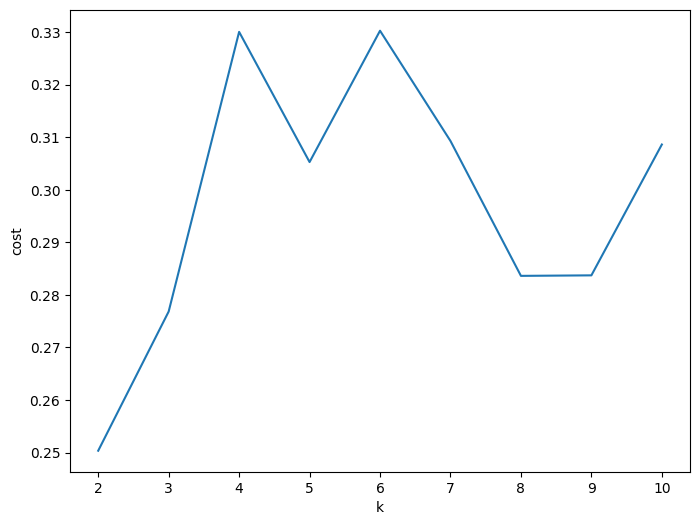

In [51]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sbs
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,11),cost[2:])
ax.set_xlabel('k')
ax.set_ylabel('cost')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

In [47]:
KMeans_algo=KMeans(featuresCol='standardized', k= 6)
KMeans_fit=KMeans_algo.fit(data_scale_output)
output=KMeans_fit.transform(data_scale_output)  
score=evaluator.evaluate(output)
score

0.330262172567472